# Capstone Project: Cybersecurity Attacks Analysis

**Overview**: For my capstone project in UC Berkeley's ML/AI bootcamp, I will be analyzing a dataset of network packets and identifying factors which determine if the packet is a cyberattack or not. The goal for the project is to train a classification model that will be able to accurately predict if a packet is normal or malign.



## Dataset

This dataset comes from [Kaggle](https://www.kaggle.com/datasets/mrwellsdavid/unsw-nb15). The data is a synthetic dataset created by "Cyber Range Lab of the Australian Centre for Cyber Security (ACCS) for generating a hybrid of real modern normal activities and synthetic contemporary attack behaviours". In total, the data has 2 million records. However, they graciously sampled the dataset and created a training and testing set of a total of 250,000 records. Thus, instead of utilizing the 2 million records, we'll be using their train/test sets to lower the computation power.

## Business Objective

Our objective in this project is to create a classification model that can accurately predict if a network packet is malignant or normal. These predictions will be based on the features in the dataset. In addition, we would like to identify features that have a strong impact on the model so that we can find what features define these attacks.

## Reading in the Data

We have already imported the training set and data set into the /data folder. So we will extract it with pandas. For now, we'll be examining the training set since the testing set shares the exact same features as the training set.

In [5]:
import pandas as pd

In [20]:
cyber_attacks = pd.read_csv( "data/UNSW_NB15_training-set.csv" )

In [22]:
cyber_attacks.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


## Exploring the Data

Now that we have loaded in the data, we should look through it for missing values and features that we may need to change or manipulate.

In [24]:
cyber_attacks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

As we can see, the training dataset has a total of 175341 records and 45 features. Although the feature names aren't that clear, the dataset also provides another dataset explaining what each feature is. ADD LINK OF FEATURE DATASET

For the target variable, we would like to use "label" feature since that determines whether the packet is normal or malign.

In addition, all the features aren't missing any values. However, as we can see from the head(), for object types like "service", it seems like unknown values are replaced with "-". So it's worth checking out the object features to see if we need to change them.

### Checking Categorical Features

In [30]:
# Check proto
cyber_attacks["proto"].value_counts()

proto
tcp       79946
udp       63283
unas      12084
arp        2859
ospf       2595
          ...  
rdp          98
netblt       98
igmp         18
icmp         15
rtp           1
Name: count, Length: 133, dtype: int64

Proto stands for the transaction protocol the network packet is using. Most notably is TCP and UDP, which are the most popular protocols used today. From what we can, there are a lot of different protocols used in the dataset. It might be computationally taxing to encode all of them. Thus, perhaps it's better to save the top protocols and truncate everything else to a "others" category.

In [35]:
# Check Service
cyber_attacks["service"].value_counts()

service
-           94168
dns         47294
http        18724
smtp         5058
ftp-data     3995
ftp          3428
ssh          1302
pop3         1105
dhcp           94
snmp           80
ssl            56
irc            25
radius         12
Name: count, dtype: int64

The Service feature is, as it is named, the service the network packet used. According to the feature dataset, the "-" value means the service is not much used. Thus, it should be fine to leave it as is. In addition, the amount of unique values isn't very large, so it should be fine to encode this feature.

In [43]:
cyber_attacks["state"].value_counts()

state
INT    82275
FIN    77825
CON    13152
REQ     1991
RST       83
ECO       12
PAR        1
URN        1
no         1
Name: count, dtype: int64

According to the documentation, the state feature "Indicates to the state and its dependent protocol". It seems fine to leave for now. But we can probably cull the records with state less than 100.

In [45]:
# Look at the target variable: Attack Category and Label
cyber_attacks["attack_cat"].value_counts()

attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64

In [47]:
cyber_attacks["label"].value_counts()

label
1    119341
0     56000
Name: count, dtype: int64

As we can see, attack_cat and label are linked, with attack_cat being more descriptive on the type of attack. Thus, for our first modeling attempt, we can just use label to try and classify network packets. In future attempts, we can expand the classes to try and differentiate different cyberattacks. This can be useful because some attacks are a lot more severe than others.

### Checking Numerical Features

Since there are so many numerical features, we'll first use .describe() to get a bird's eye view of the data and check to see if there are any anomalies

In [54]:
cyber_attacks.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,175341.000000,175341.000000,175341.000000,175341.000000,1.753410e+05,1.753410e+05,1.753410e+05,175341.000000,175341.000000,1.753410e+05,...,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000
mean,87671.000000,1.359389,20.298664,18.969591,8.844844e+03,1.492892e+04,9.540619e+04,179.546997,79.609567,7.345403e+07,...,5.383538,4.206255,8.729881,0.014948,0.014948,0.133066,6.955789,9.100758,0.015752,0.680622
std,50616.731112,6.480249,136.887597,110.258271,1.747656e+05,1.436542e+05,1.654010e+05,102.940011,110.506863,1.883574e+08,...,8.047104,5.783585,10.956186,0.126048,0.126048,0.701208,8.321493,10.756952,0.124516,0.466237
min,1.000000,0.000000,1.000000,0.000000,2.800000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,43836.000000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.278614e+01,62.000000,0.000000,1.305334e+04,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,87671.000000,0.001582,2.000000,2.000000,4.300000e+02,1.640000e+02,3.225807e+03,254.000000,29.000000,8.796748e+05,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000
75%,131506.000000,0.668069,12.000000,10.000000,1.418000e+03,1.102000e+03,1.250000e+05,254.000000,252.000000,8.888889e+07,...,5.000000,3.000000,12.000000,0.000000,0.000000,0.000000,9.000000,12.000000,0.000000,1.000000
max,175341.000000,59.999989,9616.000000,10974.000000,1.296523e+07,1.465555e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,...,51.000000,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000,1.000000


Something that's interesting is how some minimum values are just 0, which could be a recording error. For example, some packets sent are just 0, which doesn't make sense.

In [58]:
# Examine some records with values of 0
cyber_attacks[cyber_attacks["dur"] == 0].head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
57,58,0.0,arp,-,INT,1,0,46,0,0.0,...,1,1,0,0,0,1,2,1,Normal,0
58,59,0.0,arp,-,INT,1,0,46,0,0.0,...,1,1,0,0,0,1,1,1,Normal,0
938,939,0.0,arp,-,INT,1,0,46,0,0.0,...,1,1,0,0,0,1,1,1,Normal,0
939,940,0.0,arp,-,INT,1,0,46,0,0.0,...,1,1,0,0,0,1,1,1,Normal,0
3312,3313,0.0,arp,-,INT,1,0,46,0,0.0,...,1,1,0,0,0,1,1,1,Normal,0


As we can see, perhaps the time it took to send a singular packet (spkts) was so short that the record duration (dur) was rounded down to 0. Another thing to note is that perhaps each packet is source -> destination or destination -> source?

In [61]:
# See if packets can have both source and destination packets

In [65]:
cyber_attacks[(cyber_attacks["dpkts"] > 0) & (cyber_attacks["spkts"] > 0)].shape

(91059, 45)

Interestingly, there are only 91059 records of packets from both source and destination. Perhaps this is due to the network protocol used for the packet. From this, it seems like having 0 as a value isn't a huge deal for some of the data since it might be one-way.

### Summary of Exploration Results

From what we found, the data is very well prepared, with nothing missing. In addition, the target variable can be represented by both the "label" and "attack_cat" features. Both are interlinked, with "attack_cat" being more descriptive on what kind of attack/type the packet is and "label" simply designating the packet as malign or normal.

Besides that, we discovered a few things we need to do when cleaning the data:
1) The "Proto" feature has over 100 unique values. Thus, it might be costly to encode it. So, we should truncate it to only the top frequent protocols instead
2) We need to remove id from the dataset
3) When preparing the data, we need to remove both "label" and "attack_cat" since they directly tie to the target variable.

## Preparing/Engineering the Features

From what we discovered from our exploration, we now need to prepare the data for training.

### Preparing the Data

In [73]:
# Remove the id
filtered_attacks = cyber_attacks.drop( ["id"], axis = 1 )
filtered_attacks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                175341 non-null  float64
 1   proto              175341 non-null  object 
 2   service            175341 non-null  object 
 3   state              175341 non-null  object 
 4   spkts              175341 non-null  int64  
 5   dpkts              175341 non-null  int64  
 6   sbytes             175341 non-null  int64  
 7   dbytes             175341 non-null  int64  
 8   rate               175341 non-null  float64
 9   sttl               175341 non-null  int64  
 10  dttl               175341 non-null  int64  
 11  sload              175341 non-null  float64
 12  dload              175341 non-null  float64
 13  sloss              175341 non-null  int64  
 14  dloss              175341 non-null  int64  
 15  sinpkt             175341 non-null  float64
 16  di

In [132]:
# Truncate proto feature
filtered_attacks["proto"].value_counts()[:10]

proto
tcp       79946
udp       63283
unas      12084
arp        2859
ospf       2595
sctp       1150
any         300
gre         225
sun-nd      201
ipv6        201
Name: count, dtype: int64

We can just use all protocols with more than 1000 records, everything else will become "other"

In [155]:
proto_gt_1000 = filtered_attacks["proto"].value_counts() > 1000
retained_proto = set( proto_gt_1000.index[proto_gt_1000] )
filtered_attacks["protocol"] = filtered_attacks["proto"].apply( lambda x : x if x in retained_proto else "other" )
print( filtered_attacks["protocol"].value_counts() )

protocol
tcp      79946
udp      63283
other    13424
unas     12084
arp       2859
ospf      2595
sctp      1150
Name: count, dtype: int64
(175341, 45)


Now we cut down the protocols to just 7 unique values instead of 100. This will probably improve the fitting time extraordinarily.

### Engineering the features
Now we want to split the data into features and target variable. In addition, we want to create the transformer to transform all the data into usable features.

#### Transformer
Now we create the transformer to transform our data

In [75]:
# We use the column transformer to transform our data
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# We use OneHotEncoding for all string features and Standard Scaler for all numerical features
# We skip the cyclical features since they don't need to be scaled.
transformer = make_column_transformer( 
    ( OneHotEncoder( drop = "if_binary", handle_unknown='ignore' ), make_column_selector( dtype_include=object ) ),
    remainder = StandardScaler() )

### Train / Test Split
Now that we finished cleaning and engineering the data, we can use the given training set and testing set since they're already provided. Only thing we need to do is filter out id and the target variables. For this first attempt, we will just be using "label" for classification.

In [164]:
test_data = pd.read_csv( "data/UNSW_NB15_testing-set.csv" )
test_data["protocol"] = test_data["proto"].apply( lambda x : x if x in retained_proto else "other" )
test_data = test_data.drop( "id", axis = 1 )

X_train, y_train = filtered_attacks.drop( ["label","attack_cat","proto"], axis = 1 ), filtered_attacks["label"]
X_test, y_test = test_data.drop( ["label","attack_cat"], axis = 1 ), test_data["label"]

print( len(X_train), len(X_test), len(y_train), len(y_test) )

175341 82332 175341 82332


As we can see, the train-test split is around 66-33. Thus, if our models aren't performing that well, it might be worth changing the proportions a little.

## Baseline Model
Now we can start training models. The first thing we should do is see what the baseline is. What is the bare minimum that our models need to beat?

In [283]:
# The baseline model should just be a model that returns the most frequent value
# We use the Dummy Classifier to do this
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
import time

start = time.time()
baseline_model = DummyClassifier().fit( X_train, y_train )
end = time.time()

baseline_fittime = end - start

baseline_trainScore = accuracy_score( y_train, baseline_model.predict( X_train ) )
baseline_testScore = accuracy_score( y_test, baseline_model.predict( X_test ) )                       

print( "Training Accuracy", baseline_trainScore )
print( "Testing Accuracy", baseline_testScore )

Training Accuracy 0.6806223302022916
Testing Accuracy 0.5506000097167566


As we can see, our model needs to beat an accuracy of 55%. As for recall, we can't really use the baseline model for the baseline recall since it will simply have a recall of 1 (the majority of labels are malign packets). However, we do want to try aiming for recall and predict as many malign packets as possible.

In [267]:
baseline_recall_trainScore = recall_score( y_train, baseline_model.predict( X_train ) )
baseline_recall_testScore = recall_score( y_train, baseline_model.predict( X_train ) )

print( "Training Recall", baseline_recall_trainScore )
print( "Testing Recall", baseline_recall_testScore )

Training Recall 1.0
Testing Recall 1.0


## First Attempt At Training Models
For our first attempt at training models, we will be using K-Nearest Neighbors, Decision Tree, Logistic Regression, and SVM models. For each one, we'll be training while doing a small hyperparameter search to optimize each model a little bit. In addition, we'll look at recall as well since we want to pay attention to how well we identify malign packets.

### Simple Model Testing
Before going head deep into model training and hyperparameter searching, we'll first train a simple Logistic Regression model to see how long fitting takes and how accurate the model will be:

In [168]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

start = time.time()
pipe = Pipeline([
    ( "transform", transformer ),
    ( "lgr", LogisticRegression( max_iter = 1000 ) )
]).fit( X_train, y_train )
end = time.time()

fit_time = end - start
lgr_trainAccScore = accuracy_score( y_train, pipe.predict( X_train ) )
lgr_testAccScore = accuracy_score( y_test, pipe.predict( X_test ) )
lgr_trainRecallScore = recall_score( y_train, pipe.predict( X_train ) )
lgr_testRecallScore = recall_score( y_test, pipe.predict( X_test ) )

print( "Training Accuracy: ", lgr_trainAccScore )
print( "Training Recall: ", lgr_trainRecallScore )
print( "Testing Accuracy: ", lgr_testAccScore )
print( "Testing Recall: ", lgr_testRecallScore )
print( "Fitting Time: ", fit_time )

Training Accuracy:  0.935326021865964
Training Recall:  0.9876572175530622
Testing Accuracy:  0.8092843608803382
Testing Recall:  0.9718300538251124
Fitting Time:  3.383155345916748


It looks like the fitting time is pretty long, perhaps due to the amount of features created from the encoding. Thus, it might take a while to do hyperparameter searching. Besides the fitting time, we can see that the basic model already does very well compared to the baseline model with an accuraccy of 81% and a recall of 97%. It's impressive how high the recall is since we're aiming to have as high recall as possible.

### Hyperparameter Searching

Now that we got a sneak peak at how the models will perform, we'll start training KNN, Logistic Regression, Decision Trees, SVC and searching hyperparameters for them. For our scoring metric, we'll use recall since we want to maximize the amount of malign packets we can identify. It's fine if we mistake a normal packet for a malign packet since we're just being careful. However, if we identify a malign packet as normal, the consequences could be severe.

In [185]:
# To save writing redundant code, we create a method to train and test each model
from sklearn.model_selection import GridSearchCV

def searchTrainAndScore( classifier, param_grid ):
    
    pipe = Pipeline([
        ( "transform", transformer ),
        ( "classifier", classifier )
    ])
    
    grid = GridSearchCV( pipe, param_grid, scoring = "recall", n_jobs = -1 )
    grid.fit( X_train, y_train )
    
    trainScore = grid.score( X_train, y_train )
    testScore = grid.score( X_test, y_test )
    
    time = np.mean( grid.cv_results_["mean_fit_time"] )
    print( trainScore, testScore, time )
    
    return [trainScore, testScore, time, grid]

#### Logistic Regression

In [190]:
# Logistic Regression
# For the param grid, we test out different solvers and hyperparameters
import numpy as np
from sklearn.linear_model import LogisticRegression

logreg_param_grid = { "classifier__solver": ["liblinear","lbfgs"], 
              "classifier__C": np.linspace(0.1, 5, 5), 
              "classifier__tol": np.linspace(0.00001,0.001, 5), 
              "classifier__max_iter": [1000]}

logreg_gridresults = searchTrainAndScore( LogisticRegression(), logreg_param_grid )

0.9887884297936166 0.972271243271861 45.85871708774566


In [269]:
# Get the accuracy as well
logreg_test_acc = accuracy_score( y_test, logreg_gridresults[3].predict( X_test ) )
print( "Logistic Regression Accuracy: ", logreg_test_acc )

Logistic Regression Accuracy:  0.8065029393188554


We can see that the accuracy is a tiny bit worse than our first lgr model, but the recall has improved slightly as a result to our optimizing.

#### K Nearest Neighbors

In [196]:
# K Nearest Neighbors
# For the param grid, we change the # of neighbors and how neighbors are weighted
from sklearn.neighbors import KNeighborsClassifier

KNN_param_grid = { "classifier__n_neighbors": [i for i in range( 1, 21, 2 )], "classifier__weights": ["uniform", "distance"]}

knn_gridresults = searchTrainAndScore( KNeighborsClassifier(), KNN_param_grid )

0.9815235334042784 0.9788449660284126 0.6936948537826537


In [271]:
# Get the accuracy as well
knn_test_acc = accuracy_score( y_test, knn_gridresults[3].predict( X_test ) )
print( "KNN Accuracy: ", knn_test_acc )

KNN Accuracy:  0.835118787348783


Similarly, the KNN model has similar results to the Logistic Regression but did better in both accuracy and recall.

#### Decision Tree

In [213]:
# Decision Tree
# For the param grid, we change the hyperparameters that decide on splits
from sklearn.tree import DecisionTreeClassifier

tree_param_grid = {"classifier__min_impurity_decrease":[0, 0.01,0.05,0.1,0.5], 
                   "classifier__max_depth":[2,5,10,20,None],
                   "classifier__min_samples_split":[2,4,5],
                    "classifier__criterion":["gini","entropy"] }

tree_gridresults = searchTrainAndScore( DecisionTreeClassifier(), tree_param_grid )

1.0 1.0 3.1701014553705846


In [273]:
# Get the accuracy as well
tree_test_acc = accuracy_score( y_test, tree_gridresults[3].predict( X_test ) )
print( "Decision Tree Accuracy: ", tree_test_acc )

Decision Tree Accuracy:  0.5506000097167566


Unfortunately, since we scored the decision tree by recall, it simply became the baseline model and just chose the majority label (which is the malign label. Thus, for decision trees, we need to train under accuracy instead of recall

In [247]:
# Train the decision tree again, but score based on accuracy instead
tree_pipe = Pipeline([
        ( "transform", transformer ),
        ( "classifier", DecisionTreeClassifier() )
    ])
    
tree_grid = GridSearchCV( tree_pipe, tree_param_grid, scoring = "accuracy", n_jobs = -1 )
tree_grid.fit( X_train, y_train )

trainScore = tree_grid.score( X_train, y_train )
testScore = tree_grid.score( X_test, y_test )

time = np.mean( tree_grid.cv_results_["mean_fit_time"] )
print( trainScore, testScore, time )

tree_gridresults2 = [trainScore, testScore, time, tree_grid]

0.9223570072031071 0.7670650536850799 3.0905985403060914


In [277]:
# Get the recall as well
tree2_test_recall = recall_score( y_test, tree_gridresults2[3].predict( X_test ) )
print( "Decision Tree 2 Recall: ", tree2_test_recall )

Decision Tree 2 Recall:  1.0


Impressively, the decision tree trained with accuracy still obtained a recall of 100% while also improving accuracy by around 20%.

#### SVC

In [489]:
# SVC
# For SVC, training already takes a really long time, so we can only do a small grid search
from sklearn.svm import SVC

svc_param_grid = {"classifier__kernel": ["rbf","poly","sigmoid"], "classifier__probability": [True]}

svc_gridresults = searchTrainAndScore( SVC(), svc_param_grid )

0.9964471556296662 0.9947277861113563 9109.979828039804


In [279]:
# Get the accuracy as well
svc_test_acc = accuracy_score( y_test, svc_gridresults[3].predict( X_test ) )
print( "SVC Accuracy: ", svc_test_acc )

SVC Accuracy:  0.8159403391148035


As we can see, the recall of our SVC model is very high, almost reaching a perfect score. The accuracy is around the same as the other models. However, the training and predicting takes ages to finish, meaning it's hard to fully optimize the SVC or utilize it for high demand.

### Results

Impressively enough, all of our optimized models had a recall of 97% and higher. In addition, the decision tree model managed to score perfect recall for both training and testing data while also not taking too long to fit. On the other hand, the Logistic Regression and SVC models required a lot of time to finish training. Thus, we shouldn't delve too much into searching for these two models if we choose to train again. Perhaps this is due to the large amount of features and records in the data?

In [305]:
# Create the Dataframe to contain our results
grid_results_df = pd.DataFrame( {"model":["KNN","Logistic Regression", "SVC", "Decision Tree\n(Recall)", "Decision Tree\n(Accuracy)", "Baseline"], 
                                 "Test Recall Score":[knn_gridresults[1], logreg_gridresults[1], svc_gridresults[1], tree_gridresults[1], tree2_test_recall, baseline_recall_testScore], 
                                 "Test Accuracy Score":[knn_test_acc, logreg_test_acc, svc_test_acc, tree_test_acc, tree_gridresults2[1], baseline_testScore],
                                 "Fit Time":[knn_gridresults[2], logreg_gridresults[2], svc_gridresults[2], tree_gridresults[2],tree_gridresults2[2],baseline_fittime]})

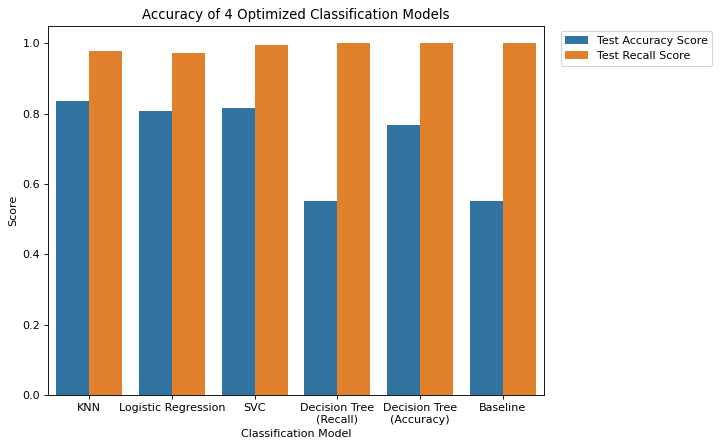

In [307]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the recall scores for more clarity
tidy = grid_results_df.melt( id_vars="model", value_vars=["Test Accuracy Score", "Test Recall Score"]).rename(columns=str.title)
plt.figure( figsize=(8, 6), dpi=80 )
graph = sns.barplot( tidy, x = "Model", y = "Value", hue = "Variable" )

#graph.axhline( baseline_testScore, color = "r", label = "Baseline" )

plt.legend(bbox_to_anchor=(1.35, 1) )
#
plt.title( "Accuracy and Recall of Optimized Classification Models + Baseline" )
plt.xlabel( "Classification Model" )
plt.ylabel( "Score" )
plt.savefig( "images/optimalModels.png", bbox_inches='tight' )

Looking at the graph, we can see that all the models have improved accuracy compared to the baseline while also sporting high recall. However, it's difficult to compare this to the baseline with a recall of 100%. In addition, this doesn't give a very clear picture on which model performed the best.

Thus, for a clearer depiction, we'll use Precision-Recall curves to get a better picture of how well each model did. For each model, the closer the curve is to the top right corner, the better the model.

In [348]:
precision_recall_curve( y_test, tree_gridresults[3].predict_proba( X_test )[:,1] )

(array([0.55060001, 1.        ]), array([1., 0.]), array([0.68062233]))

In [493]:
from sklearn.metrics import precision_recall_curve

# Get all the models in a list
models = [(knn_gridresults[3], "KNN"), 
          (logreg_gridresults[3], "Logistic Regression"), 
          (svc_gridresults[3], "SVC" ), 
          (tree_gridresults[3], "Decision Tree (Recall)"), 
          (tree_gridresults2[3], "Decision Tree (Accuracy)"), 
          (baseline_model, "Baseline")]

warnings.filterwarnings("ignore", category=FutureWarning)

precision, recall, modelNames = [], [], []
for model, modelName in models:
    p, r, t = precision_recall_curve( y_test, model.predict_proba( X_test )[:,1] )
    precision += list( p )
    recall += list( r )
    modelNames += [modelName] * len( p )

graph_df = pd.DataFrame( {"Precision": precision,
                          "Recall": recall,
                          "Model": modelNames } )

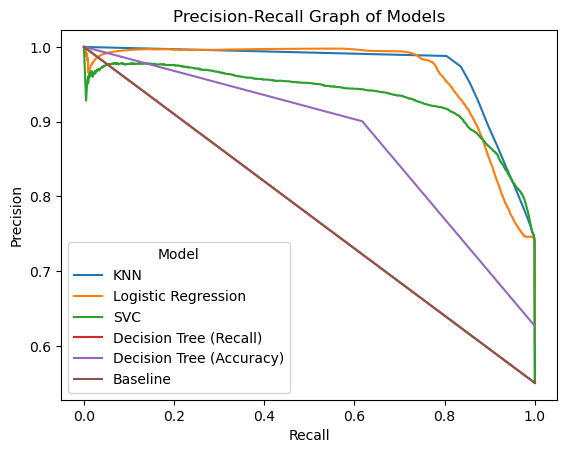

In [495]:
sns.lineplot( data = graph_df, x = "Recall", y = "Precision", hue = "Model" )
plt.title( "Precision-Recall Graph of Models" )
plt.savefig( "images/precisionRecall.png", bbox_inches='tight' )

## Model Training Review/Summary

As we can see, each classification model performs very well at predicting if a packet is malign, with the lowest recall being at 97%. As for accuracy, the models all share around 80% with the recall-trained decision tree having the lowest, matching the baseline. Using a precision-recall graph, we can see that the KNN model performed the best in terms of predicting malign packets.

From these results, we can clearly see that there are factors/patterns that allows these models to strongly identify packets. Thus, our next step is to unravel exactly what these features are. Since all the models performed well, it might be worth analyzing each one to see any overlap.

## Analyzing the Models

To identify the variables that strongly impacts our models, we'll examine each one to find any similarities.

### Decision Tree

The easiest model of the bunch, we can examine the branches of the decision tree to see which features helped split the data as much as possible, implying that they strongly impact the tree. We will be using the accuracy-trained decision tree as the recall-trained decision tree is just the baseline model.

In [376]:
from sklearn.tree import plot_tree

In [385]:
# Get the decision tree and transformer out
tree = tree_gridresults2[3].best_estimator_.named_steps["classifier"]
feature_names = tree_gridresults2[3].best_estimator_.named_steps["transform"].get_feature_names_out()

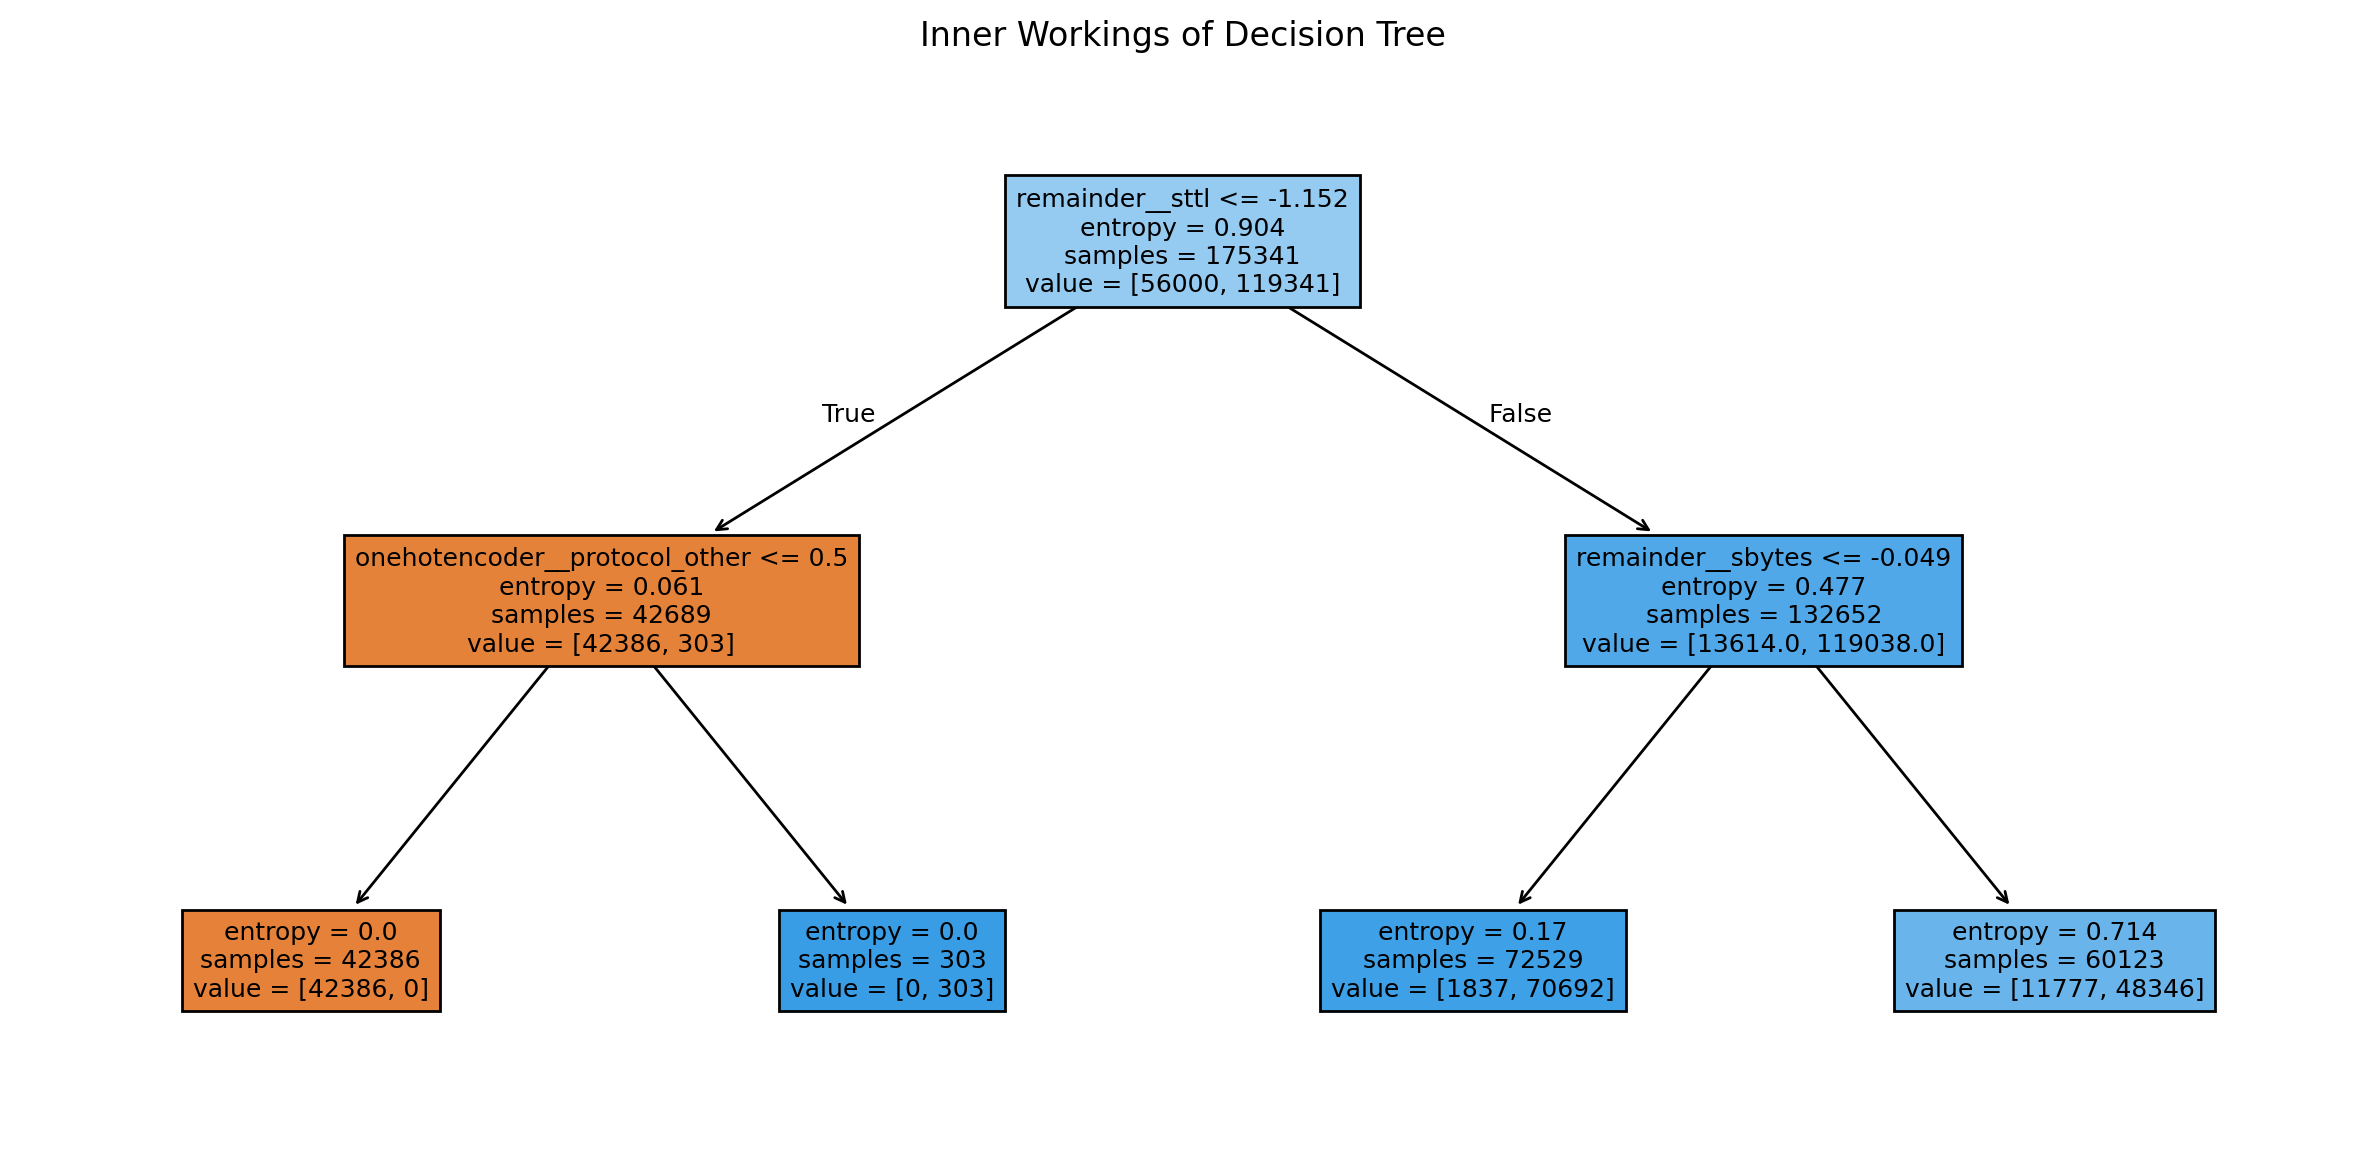

In [487]:
plt.figure( figsize=(15, 7), dpi=200 )
tree_plot = plot_tree( tree, fontsize = 9, filled = True, feature_names = list( feature_names ) )
plt.title( "Inner Workings of Decision Tree" )
plt.savefig( "images/decisionTree.png", bbox_inches='tight' ) 

To explain the graph, orange represents safe/normal packets while blue represents malign packets. In addition, for the "value" array, it is structured as [# of normal packets, # of malign packets]

From our decision tree graph, we can definitely see that some features have immense impact on the model. The feature "sttl", Source to Destination Time to Live value, splits the data very well. Time to live value represents the amount of time a packet can continue traveling through the internet before being discarded. Thus, we can say that a majority of normal packets have low time to live value compared to malign packets. This is probably because normal packets try to reach their destination as fast as possible while malign packets try to access a computer through as many angles as possible.

If the time to live value is low, the next idenfifier for normal packets is the protocol. Any packet utilizing the popular protocols are all normal while packets that use less used protocols are malign. This makes sense since popular protocols are highly secure and pretty hard for adversaries to go around.

If the time to live value is high, then the next determiner is "sbytes", which is source to destination transaction bytes. This just means how many bytes were sent from the source to the destination. It seems like the smaller the packet, the more likely it is for the packet to be malign while bigger packets have a higher chance of simply being normal packets. This could perhaps be because small packets don't require a long time to live value since they travel through the internet pretty fast. A reason for why larger packets are harder to identify is probably due to normal packets being large data transfer.

### K-Nearest Neighbors

There isn't really an easy way to analyze KNN. The model simply chooses the records most similar to the given point and gets the majority label. Thus, we should skip this one

### Logistic Regression

For logistic regression, we can examine the coefficients of the model first to see how impactful the features are.

In [435]:
# Get our Logistic Regression classifier
lgr = logreg_gridresults[3].best_estimator_.named_steps["classifier"]

In [441]:
# Combine the coefficients with their feature names
coefs = pd.DataFrame( zip( feature_names, lgr.coef_[0] ) )
coefs = coefs.sort_values( 1, ascending = False )

print( "Top Coefficients:" )
print( coefs[:10] )

print( "Bottom Coefficients:" )
print( coefs[-1:-10:-1] )

Top Coefficients:
                                  0         1
36                  remainder__dttl  5.630442
16         onehotencoder__state_INT  3.200808
9       onehotencoder__service_smtp  2.761648
53                 remainder__dmean  2.267573
25     onehotencoder__protocol_sctp  2.254803
2        onehotencoder__service_dns  2.155266
28     onehotencoder__protocol_unas  1.887431
24    onehotencoder__protocol_other  1.693415
4   onehotencoder__service_ftp-data  1.626375
31                 remainder__dpkts  1.446123
Bottom Coefficients:
                              0         1
38             remainder__dload -5.013337
45              remainder__swin -3.585134
27  onehotencoder__protocol_udp -2.858518
3    onehotencoder__service_ftp -2.825630
13     onehotencoder__state_CON -2.561782
0      onehotencoder__service_- -2.492135
26  onehotencoder__protocol_tcp -1.833781
48              remainder__dwin -1.772445
66        remainder__ct_srv_dst -1.565681


The greater the value of the coefficient, the more impact it has on the model. In addition, all the features are scaled pretty well, so they should all be relatively equal in value. Negative coefficients indicate the packet is normal while positive coefficients indicate the packet is malign.

As we can see, protocol appears multiple times in the list. Popular protocols such as TCP and UDP have high negative coefficients, indicating that packets using these protocols are normal. Protocols that aren't prevalent such as SCTP or UNAS have high postive coefficients, implying that malign packets use less popular protocols when being sent.

Service is also another feature that seems to impact both normal and malign packets. Normal packets usually use FTP (communication) and other non-used services. Malign packets, on the other hand, utilize FTP-data (data transfer), DNS (computer lookup), and SMTP (mail service). This indicates that malign packets focus more on data transfering or obtaining information.

Interestingly, Logistic Regression identifies destination information to be aligned to malign packets. The most notable none is "dttl", or destination to source time to live value. Perhaps this is due to the same reasoning given for decision trees, but it is strange how "sttl" doesn't show up if it's true.

As for indicators for normal packets, the most impactful are "dload", destination bits per second, and "swin", TCP window advertisement value. Destination bits per second might be an indicator because higher bits per second implies a pretty stable and secure connection with no malign packets. As for TCP window advertisement value (how much data can be accepted), the same logic could apply where larger windows implies a more stable and secure connection.

In [455]:
# Just to confirm our analysis, we'll use permutation_importance to go through the model again

from sklearn.inspection import permutation_importance

# Find the importance means for the logistic regression model
lgr_pipe = logreg_gridresults[3].best_estimator_
r = permutation_importance( lgr_pipe, X_test, y_test, scoring = "recall" )

# We want to record the importance means
importance_means = {}
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_test.columns[i]:<20}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")
        importance_means[X_test.columns[i]] = r.importances_mean[i]

swin                0.277 +/- 0.001
dttl                0.200 +/- 0.001
dload               0.070 +/- 0.001
sttl                0.066 +/- 0.001
ct_srv_dst          0.063 +/- 0.001
state               0.062 +/- 0.000
service             0.038 +/- 0.001
dmean               0.037 +/- 0.001
dwin                0.028 +/- 0.001
ct_state_ttl        0.027 +/- 0.001
protocol            0.022 +/- 0.000
is_sm_ips_ports     0.011 +/- 0.000
dbytes              0.009 +/- 0.000
ackdat              0.003 +/- 0.000
dpkts               0.002 +/- 0.000
rate                0.001 +/- 0.000
djit                0.001 +/- 0.000
ct_srv_src          0.001 +/- 0.000
spkts               0.001 +/- 0.000
sloss               0.000 +/- 0.000
sinpkt              0.000 +/- 0.000
dtcpb               0.000 +/- 0.000
sbytes              0.000 +/- 0.000
ct_src_ltm          0.000 +/- 0.000


As we can see, many features we've seen before in our above analysis, "swin", "dttl", "dload", "protocol", "service", "sttl", have high importance in the model. 

### SVC

For SVC, we can examine the coefficients if the model is linear. So lets first check what kernel was used

In [462]:
svc_gridresults[3].best_params_

{'classifier__kernel': 'poly'}

Unfortunately, the SVC used a "poly" kernel, so we can't use .coef_. Thus, our only other choice is to use permutation_importance again:

In [466]:
# Find the importance means for the SVC model
svc_pipe = logreg_gridresults[3].best_estimator_
r = permutation_importance( svc_pipe, X_test, y_test, scoring = "recall" )

# We want to record the importance means
importance_means = {}
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_test.columns[i]:<20}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")
        importance_means[X_test.columns[i]] = r.importances_mean[i]

swin                0.277 +/- 0.000
dttl                0.199 +/- 0.000
dload               0.070 +/- 0.001
sttl                0.066 +/- 0.001
state               0.063 +/- 0.001
ct_srv_dst          0.062 +/- 0.001
dmean               0.037 +/- 0.000
service             0.037 +/- 0.001
dwin                0.028 +/- 0.000
ct_state_ttl        0.028 +/- 0.001
protocol            0.021 +/- 0.001
is_sm_ips_ports     0.010 +/- 0.000
dbytes              0.008 +/- 0.000
ackdat              0.003 +/- 0.000
dpkts               0.001 +/- 0.000
rate                0.001 +/- 0.000
djit                0.001 +/- 0.000
ct_srv_src          0.001 +/- 0.000
spkts               0.000 +/- 0.000
sloss               0.000 +/- 0.000
smean               0.000 +/- 0.000
dtcpb               0.000 +/- 0.000
sinpkt              0.000 +/- 0.000
dur                 0.000 +/- 0.000
sbytes              0.000 +/- 0.000
ct_src_ltm          0.000 +/- 0.000


From the results, we can see that the top features are "swin" and "dttl", which were both discussed in the previous model analysis. Following them are "dload", "sttl", "state", and "ct_srv_dst" (# of same connections in 100 connections to destination). It's hard to tell if "ct_srv_dst" is an indicator for normal or malign. If the same connection happens very often, then perhaps it is an indicator of a DDOS attack, which would be malign. However, it could be just a private connection between two parties as well.

Besides that, other features we've seen before such as "dmean", "service", "dwin", and "protocol" still have impact on the SVC.

### Summary of Analysis

After we analyzed all 4 models, we can definitely see some stand-out impactful features that overlapped in all of them. These all involve either the packet details or the protocol used to send them.

* We found that "Time to live value" is very impactful in determining whether a packet is normal or malign. Lower values lead to normal packets while higher values point toward malignant packets.
* High values in features dealing with packet size and limit such as TCP window advertisement value, bits per second, mean transmited packet size have a strong indication of a normal packet. This is probably because they imply a stable and secure connection between two parties rather than a sneaky method of injecting a malign packet.
* Protocol is also a very strong factor in determining a packet's validity. Packets that utilize popular protocols such as TCP, UDP, and FTP strongly suggests that the packets are normal. This is probably due to the amount of scrutinance and work put into these protocols to make them as secure and safe as possible. Meanwhile, packets that utilize less frequently used protocols have a higher rate of being a malign packet. This is probably due to there being more security holes and supervision when using these protocols.
* Service is another feature that is impactful. This seems to go hand in hand with the "Protocol" feature, as malign packets seem to use certain services while normal packets usually utilize other states. For example, DNS, FTP-Data, and SMTP are strong indicators of malign packets perhaps due to them trying to transfer harmful agents through mail or an FTP connection. Interestingly, the FTP service is indicative of a normal packet, probably because it's a minimal and secure connection between two parties that isn't really risky.
* Lastly, "State" is also high up as another impactful feature. It seems like State is dependent on the "Protocol" feature and simply designates what kind of state the protocol is in. Thus, we can lump this in with the protocol. The most important states are "CON", which implies a normal packet, and "INT", which implies a malign packet

In essense, we can determine if a packet is normal or malignant by examining the packet transmission details and utilized protocol services. Most malignant packets utilize less popular and secure protocols while normal packets utilize popular protocols such as TCP and UDP. In addition, malignant packets usually have longer life time on the internet and are smaller than normal packets.

## Summary

With a dataset of network packets collected by the Australian Centre for Cyber Security, we trained multiple classification models to determine whether a network packet was normal or malign. Once trained, all of the models had pretty high performance, sporting 80% accuracy and around 97% recall. After training the models, we examined each model to find features that strongly impacted the models in their predictions. These features are strong indicators for normal or malign packets, allowing us to gain some insight on how these models work. From our analysis, we deduced that the strongest indicators for a network packet are the packet transmission details and utilized service/protocol. Malign packets and normal packets seem to utilize different protocols when being sent. In addition, while malign packets are usually small in size and try to last on the network for as long as possible, normal packets tend to be larger in size and are transferred more securely.

## Next Steps and Recommendations

With such a high recall and accuracy for every model, a next step would be to utilize these classification models in cybersecurity tools that identify malign packets. This way, people can be more protected against malignant agents trying to steal their information or assets. Another way is just to inform cybersecurity experts about these results, discussing which features are strong indicators and seeking what their opinion is on the matter. This creates discussion and spreads discourse about identifying network packets, which will keep people's digital lives safer in the long run.

In addition, although our models performed well, it's worth using data provided by other sources to confirm/reject the current results we've gotten. The dataset we used for this project is synthetic, meaning that not all of it is real data. This raises the concern that perhaps the data might be completely reflective of real life network packets. Thus, it's worth double checking by utilizing other data.

Besides that, another next step is focusing on creating more accurate models. Currently, Logistic Regression and SVC take a really long time to fit (even with all my computer's processors working in tandam). As such, it's just not feasible to conduct deep hyperparameter searches for these models. However, from our analysis, we've confirmed that many features simply don't have any impact on the model. Thus, if we were to trim the dataset to only include the impactful features, it will be easier to conduct deeper hyperparameter searches for our models. In addition, we can utilize more advanced models such as Random Forests to get better classification models.

For recommendations, I would suggest people to use popular network protocols when transferring data. It's only when you start using less used protocols or access less secure sites/downloads when you begin to run across malignant network packets. For general folk, it would probably boil down to just being aware of the dangers of receiving suspicious advertisements or download links and not accessing insecure web sites.

## Reflection

There are a few things that I would have liked to have done better.

First and foremost was to check the validity and usability of the data with my own eyes rather than other people's opinion. The first dataset I found seemed like a perfect find that contained enough data and features to conduct good analysis. However, as I dove deeper into the dataset, I noticed that all of the models were performing as well as the baseline model. Further testing led to me realizing that the dataset I used was so synthetic that the distribution of features for each label were completely the same. So there was no insight or information to be gained. I wasted so much time and effort on this one dataset and grew frustrated. However, I was able to find this current dataset, which provided me with a lot more usable data and insight to complete the project. Thus, a lesson for me to learn from.

Second, I think I could have done more during my model training. As I mentioned in my next steps, I could optimize the dataset and conduct deeper searches for the models to get a higher accuracy and recall score. I also think that the range of some of the hyperparameters I was searching for could be expanded as well.

Lastly, I feel like I could explain the features a bit better or translate their names into more readable/clearer titles. Most of it is internet protocol terminology, so it could get confusing for a layman to understand what each feature represents. Perhaps I should have added the entire features description as a section in this report?